### Data

In [95]:
import pandas as pd
import numpy as np

data = pd.read_csv("./bml-component-data.csv")

# Scale time column
data["timestamp"] /= 10000
data = data.drop(columns=["index"])

In [96]:
def pad(array, target_length):
    """Pads 1D array to target length using -1 constant as padding."""

    n_pad = target_length - array.shape[0]
    return np.pad(array, (0, n_pad), mode="constant", constant_values=[-1])

In [97]:
# Collect all values from each CX into one row and put timestamps and efficiencies into np arrays
data_grouped = data.groupby(["ID"]).agg(list)
data_grouped = data_grouped.map(np.array)

# Each row is exactly one CX
x = list(data_grouped["timestamp"])
y = list(data_grouped["efficiency"])

# Rows are ragged (rows aren't all the same length) so padding is required
max_obs = max([len(row) for row in y])

x_padded = np.array([pad(row, max_obs) for row in x])
y_padded = np.array([pad(row, max_obs) for row in y])

# Generate mask (True for actual values, False for padded values)
mask = x_padded != -1

In [98]:
# Generate M1 to M5 arrays. Each M value is the same for all measurements within a CX component
M_df = data.drop_duplicates(subset=["ID"])

# M[0] is all M1 values, M[1] is all M2 values etc.
M = np.array([M_df["M1"], M_df["M2"], M_df["M3"], M_df["M4"], M_df["M5"]])

In [99]:
import numpyro as npr
import numpyro.distributions as dist
import jax.numpy as jnp

def model(t, y, m, mask):
    sigma = npr.sample("sigma", dist.HalfNormal(1))

    # Generate u_i and v_i for all CX components
    with npr.plate("cx-component", t.shape[0]):
        u = npr.sample("u", dist.Normal(90, 10)) #dist.Normal(u_alpha, u_beta))
        v = npr.sample("v", dist.Normal(5, 5)) #dist.Normal(v_alpha, v_beta))

    with npr.plate("m", m.shape[0]):
        w = npr.sample("w", dist.Normal(0, 1))

    # Make predictions of f_i(t) then sample from normal dist with variance sigma to account for noise
    with npr.plate("observations", t.shape[1]):
        with npr.handlers.mask(mask=mask):
            m_sum = -(v + jnp.dot(w, m))
            f = u[:, jnp.newaxis] * jnp.exp(m_sum[:, jnp.newaxis] * t)
            npr.sample("obs", dist.Normal(f, sigma), y)

In [100]:
from jax import random
from numpyro.infer import MCMC, NUTS


seed = 0
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
rng_key = random.PRNGKey(seed)
mcmc.run(rng_key, t=x_padded, y=y_padded, m=M, mask=mask)
mcmc.print_summary()

C:\Users\jayde\AppData\Local\Temp\ipykernel_29200\102165473.py:9: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  mcmc.run(rng_key, t=x_padded, y=y_padded, m=M, mask=mask)
sample: 100%|██████████| 1500/1500 [00:11<00:00, 134.40it/s, 255 steps of size 1.98e-02. acc. prob=0.93]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      5.08      0.13      5.08      4.84      5.27   1818.72      1.00
      u[0]     92.01      2.60     92.03     87.55     96.37   5968.98      1.00
      u[1]     91.77      2.62     91.77     87.24     95.84   3506.51      1.00
      u[2]     92.78      2.48     92.75     89.10     97.14   3342.72      1.00
      u[3]     91.13      4.28     91.16     83.91     97.98   2260.30      1.00
      u[4]     88.35      4.17     88.27     81.58     94.82   1389.59      1.00
      u[5]     96.18      6.66     96.16     85.22    106.88   2154.32      1.00
      u[6]     91.11      4.78     91.17     83.36     99.42   3354.70      1.00
      u[7]     90.85      4.46     90.82     83.63     98.07   2986.81      1.00
      u[8]    102.49      4.26    102.22     95.77    109.55   2443.06      1.00
      u[9]     89.16      4.47     89.25     81.93     96.61   3287.86      1.00
     u[10]    100.02      3

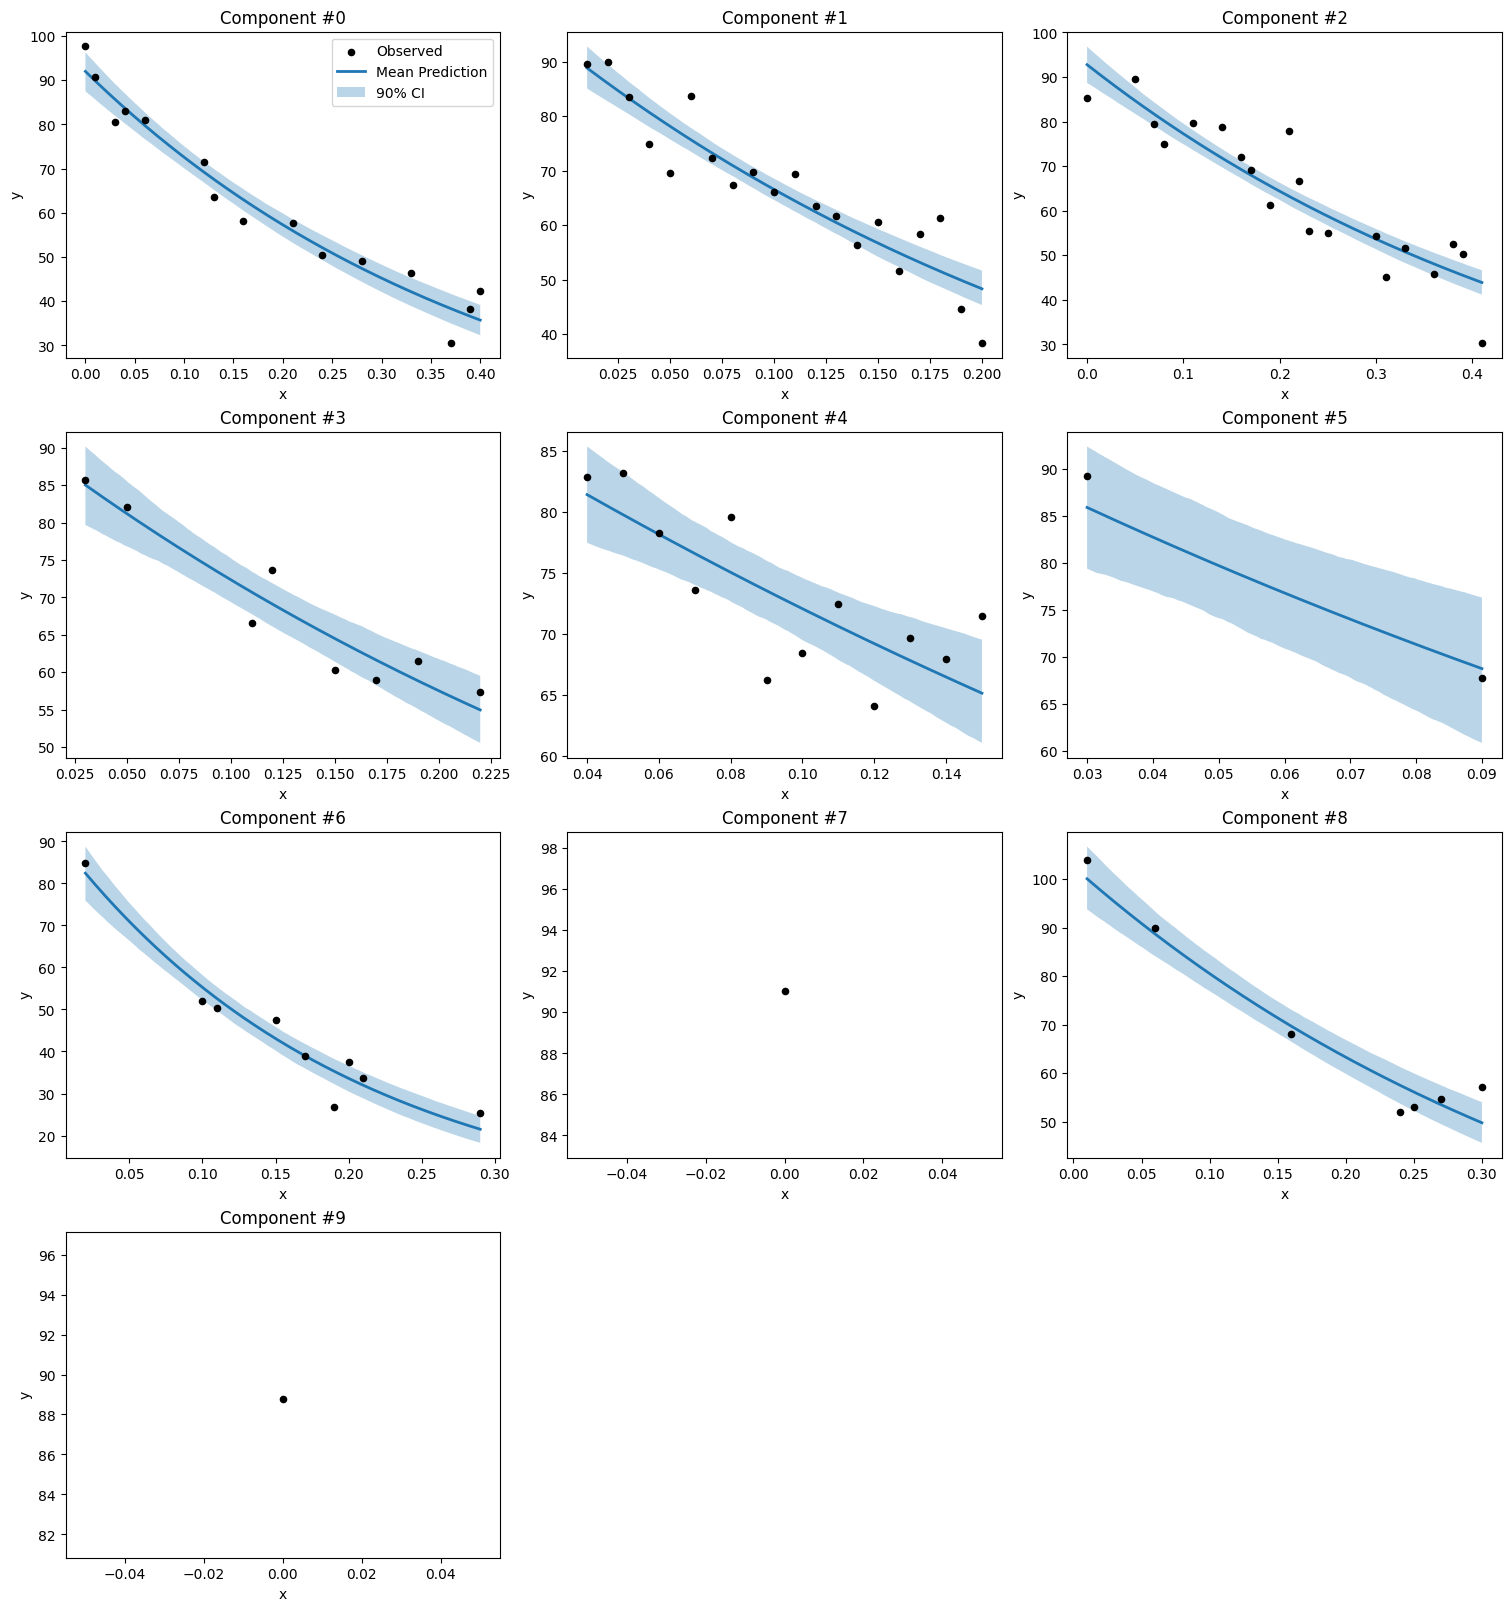

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

def plot_component_fits(mcmc, x_data, y_data, mask, M, num_plots=6):
    """
    Plots observed data vs inferred decay curves with 90% CI,
    using the full model with M and w weights.
    """
    samples = mcmc.get_samples()
    u = samples['u']        # (num_samples, N)
    v = samples['v']        # (num_samples, N)
    w = samples['w']        # (num_samples, K)  K = features in M

    # Compute full m_sum for each sample and component: -(v_i + w·M_i)
    # w: (num_samples, K), M: (N, K) → (num_samples, N)
    m_effect = np.dot(w, M)         # (num_samples, N)
    m_sum = -(v + m_effect)           # (num_samples, N)

    cols = 3
    rows = (num_plots + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows), constrained_layout=True)
    axes = axes.flatten()

    indices_to_plot = np.arange(min(num_plots, x_data.shape[0]))

    for i, ax in zip(indices_to_plot, axes):

        valid_idx = mask[i].astype(bool)
        x_real = x_data[i][valid_idx]
        y_real = y_data[i][valid_idx]

        sort_order = np.argsort(x_real)
        x_real = x_real[sort_order]
        y_real = y_real[sort_order]

        x_smooth = jnp.linspace(x_real.min(), x_real.max(), 200)

        # Extract posterior samples for this component
        u_i = u[:, i]                # (samples,)
        m_i = m_sum[:, i]            # (samples,)

        # Compute predictions: u_i * exp(m_i * x)
        predictions = u_i[:, None] * jnp.exp(m_i[:, None] * x_smooth)

        mean_pred = jnp.mean(predictions, axis=0)
        hpdi_low = jnp.percentile(predictions, 5, axis=0)
        hpdi_high = jnp.percentile(predictions, 95, axis=0)

        ax.scatter(x_real, y_real, color='black', s=20, label='Observed', zorder=3)
        ax.plot(x_smooth, mean_pred, lw=2, label='Mean Prediction')
        ax.fill_between(x_smooth, hpdi_low, hpdi_high, alpha=0.3, label='90% CI')

        ax.set_title(f"Component #{i}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")

        if i == 0:
            ax.legend()

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.show()

plot_component_fits(mcmc, x_padded, y_padded, mask, M=M, num_plots=10)